In [ ]:
!pip install gcsfs

In [2]:
import pandas as pd
import gcsfs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import itertools
%matplotlib inline
import matplotlib as mpl
import matplotlib.style
mpl.style.use('seaborn-bright')

Reading the data files from the google cloud storage

In [3]:
fs = gcsfs.GCSFileSystem(project='omina-gcp-resource')
with fs.open('omina-test-set/occupancy-data/occupancy_data.csv') as f:
    df = pd.read_csv(f)

Changing the date variable to python datetime variable

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']
del df['Unnamed: 0']

Sorting the dataframe by date

In [5]:
df = df.sort_values(by='date')

In [6]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,,
2015-02-02 14:19:00,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
2015-02-02 14:19:59,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2015-02-02 14:21:00,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
2015-02-02 14:22:00,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
2015-02-02 14:23:00,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


Creating the NSM variavle and WS variable [NSM stands for Number of seconds since midnight for each day and WS stands for week day (1) or weekend (0)]

In [33]:
df_group = df.groupby(pd.Grouper(key = 'date', freq = 'D'))
df['NSM'] = df.date.apply(lambda x: x - x.replace(hour=0, minute=0, second=0)).dt.total_seconds()
df['WS'] = ((pd.DatetimeIndex(df.index).dayofweek) < 5).astype(int)
del df['date']
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,NSM,WS
date,,,,,,,,
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,51540.0,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,51599.0,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,51660.0,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,51720.0,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,51780.0,1


Generating the correlation table considering the entire data samples

In [34]:
df_corr =df.corr()
df_corr.head(7)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,NSM,WS
Temperature,1.000000,-0.156964,0.688571,0.449989,0.205280,0.555610,0.235422,0.412400
Humidity,-0.156964,1.000000,-0.029459,0.299746,0.932724,0.046240,0.114961,-0.215841
Light,0.688571,-0.029459,1.000000,0.448105,0.223329,0.914850,0.095023,0.267150
CO2,0.449989,0.299746,0.448105,1.000000,0.477965,0.501582,0.127287,0.372715
HumidityRatio,0.205280,0.932724,0.223329,0.477965,1.000000,0.257324,0.201703,-0.051735
Occupancy,0.555610,0.046240,0.914850,0.501582,0.257324,1.000000,0.103522,0.341949
NSM,0.235422,0.114961,0.095023,0.127287,0.201703,0.103522,1.000000,-0.004215


In [35]:
def corrcoef_loop(df): # a function to calculate the associated p-values of correlation
    cols = df.shape[1]
    p = np.zeros(shape=(cols, cols))
    for i in range(cols):
        for j in range(i+1, cols):
            r, p_values = stats.pearsonr(df.iloc[:, i], df.iloc[:, j])
            p[i, j] = p[j, i] = p_values
    return p

Calculate p-values

In [36]:
df1 = df[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'NSM', 'WS']]
df_pval = pd.DataFrame(corrcoef_loop(df1), columns = df1.columns, index = df1.columns)
df_pval.head(7)

,Temperature,Humidity,Light,CO2,HumidityRatio,NSM,WS
Temperature,0.000000e+00,1.536382e-113,0.000000e+00,0.000000e+00,1.728531e-194,6.865398e-257,0.000000e+00
Humidity,1.536382e-113,0.000000e+00,2.392676e-05,0.000000e+00,0.000000e+00,1.957769e-61,2.745444e-215
Light,0.000000e+00,2.392676e-05,0.000000e+00,0.000000e+00,1.002775e-230,1.881377e-42,0.000000e+00
CO2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.239133e-75,0.000000e+00
HumidityRatio,1.728531e-194,0.000000e+00,1.002775e-230,0.000000e+00,0.000000e+00,1.058240e-187,1.147644e-13
NSM,6.865398e-257,1.957769e-61,1.881377e-42,5.239133e-75,1.058240e-187,0.000000e+00,5.456448e-01
WS,0.000000e+00,2.745444e-215,0.000000e+00,0.000000e+00,1.147644e-13,5.456448e-01,0.000000e+00


Generating training and testing data set based on timeseries splitting

In [37]:
df_train = df['2015-02-06 00:00:00' : '2015-02-08 00:00:00']
df_train = df_train[df_train['Light'] < 700]

In [38]:
df_test = df['2015-02-02 14:19:00' : '2015-02-04 10:43:00']

In [39]:
df_test1 = df['2015-02-11 14:48:00' : '2015-02-18 09:19:00']

Plotting correlations for training dataset

In [40]:
df1 = df_train[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'NSM', 'WS']]
df_train_corr =df1.corr()
df_train_corr.head(7)

,Temperature,Humidity,Light,CO2,HumidityRatio,NSM,WS
Temperature,1.000000,-0.329698,0.718144,0.514247,0.131619,0.138897,0.160997
Humidity,-0.329698,1.000000,-0.088970,0.097855,0.891370,0.476426,-0.157312
Light,0.718144,-0.088970,1.000000,0.809379,0.268451,0.069799,0.344047
CO2,0.514247,0.097855,0.809379,1.000000,0.383238,0.151469,0.515079
HumidityRatio,0.131619,0.891370,0.268451,0.383238,1.000000,0.562218,-0.063917
NSM,0.138897,0.476426,0.069799,0.151469,0.562218,1.000000,0.000259
WS,0.160997,-0.157312,0.344047,0.515079,-0.063917,0.000259,1.000000


Calculating p-values for training dataset

In [41]:
df_train_pval = pd.DataFrame(corrcoef_loop(df1), columns = df1.columns, index = df1.columns)
df_train_pval.head(7)

,Temperature,Humidity,Light,CO2,HumidityRatio,NSM,WS
Temperature,0.000000e+00,6.123236e-74,0.000000e+00,4.456987e-194,1.353226e-12,7.182062e-14,3.624799e-18
Humidity,6.123236e-74,0.000000e+00,1.749476e-06,1.440913e-07,0.000000e+00,5.139478e-163,2.092568e-17
Light,0.000000e+00,1.749476e-06,0.000000e+00,0.000000e+00,1.075211e-48,1.786316e-04,9.076570e-81
CO2,4.456987e-194,1.440913e-07,0.000000e+00,0.000000e+00,2.439021e-101,3.096020e-16,8.344000e-195
HumidityRatio,1.353226e-12,0.000000e+00,1.075211e-48,2.439021e-101,0.000000e+00,1.416762e-239,6.014340e-04
NSM,7.182062e-14,5.139478e-163,1.786316e-04,3.096020e-16,1.416762e-239,0.000000e+00,9.889159e-01
WS,3.624799e-18,2.092568e-17,9.076570e-81,8.344000e-195,6.014340e-04,9.889159e-01,0.000000e+00


Split the dataset for training, testing and validation

In [42]:
feature_names = ['Temperature', 'Light'] #'Humidity', 'Light', 'CO2', 'HumidityRatio', 'NSM', 'WS']
X_train = df_train[feature_names]
y_train = df_train['Occupancy']
X_test = df_test[feature_names]
y_test = df_test['Occupancy']
X_test1 = df_test1[feature_names]
y_test1 = df_test1['Occupancy']

Training Logistic Regression

In [43]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.99
Accuracy of Logistic regression classifier on test set: 0.98


Training Gaussian Naive Bayes

In [44]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'.format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'.format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.98
Accuracy of GNB classifier on test set: 0.96


Training SVM

In [45]:
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'.format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 0.88


Training Random Forest

In [46]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
print('Accuracy of Random Forest classifier on training set: {:.2f}'.format(rf.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

Accuracy of Random Forest classifier on training set: 1.00
Accuracy of Random Forest classifier on test set: 0.98


Generating Confusion Matrix

In [47]:
pred = gnb.predict(X_test)
df_CM = pd.DataFrame(confusion_matrix(y_test, pred), columns = ["Predicted 0", "Predicted 1"], index = ["Actual 0", "Actual 1"])
df_CM.head()

,Predicted 0,Predicted 1
Actual 0,1639,54
Actual 1,54,918


Visualizing Confusion Matrix

In [48]:
class_names = np.array(['0', '1'])

In [49]:
def plot_confusion_matrix(conf_mat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(conf_mat)

    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes) # , rotation = 45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        plt.text(j, i, format(conf_mat[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1639   54]
 [  54  918]]
Normalized confusion matrix
[[0.97 0.03]
 [0.06 0.94]]


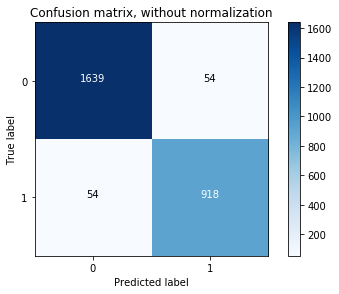

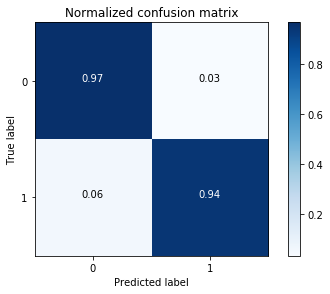

In [50]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix

plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Generating classification report

In [51]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97      1693
          1       0.94      0.94      0.94       972

avg / total       0.96      0.96      0.96      2665



Visualizing Decision Boundaries

Copying file://DT.svg [Content-Type=image/svg+xml]...
/ [1 files][  1.2 MiB/  1.2 MiB]                                                
Operation completed over 1 objects/1.2 MiB.                                      


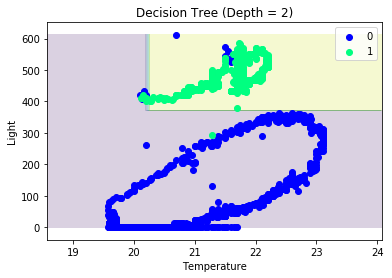

In [52]:
# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)
clf1.fit(X_train, y_train)

# Plotting decision regions
x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
#mpl.style.use('seaborn-bright')
f, fig = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(6, 4))

Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
fig.contourf(xx, yy, Z, alpha=0.2)
label = [0,1]
colors = [plt.cm.winter(float(i)/max(label)) for i in label]
for i, cluster in df_train.groupby('Occupancy'):
    fig.scatter(cluster['Temperature'], cluster['Light'], c=colors[i], label=i, s = 50)
fig.legend(loc = 'best')

#fig.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train,
#              s=50, edgecolor='none',cmap='winter')

fig.set_title('Decision Tree (Depth = 2)')
plt.xlabel('Temperature')
plt.ylabel('Light')

plt.savefig("DT.svg", format="svg")
!gsutil cp 'DT.svg' 'gs://omina-test-set/occupancy-data/figDT.svg'
plt.show()

In [53]:
plt.rcParams.update(plt.rcParamsDefault)